# Research Assistant Agent

The goal of this notebook is to prototype a multi-agent system that strategically gathers and uses context in order to generate more reliable answers. Inspired by the [STORM](https://arxiv.org/pdf/2402.14207) research paper by Stanford University, this is a custom implementation of `Multi-Perspective Question Answering` where the system looks at the question from different perspectives and starts multiple conversations with experts for the research phase. To understand the concept in more detail, please follow along in this notebook.

The system has the following features:
1. **Planning:** Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic. `Human-in-the-loop` will be used to refine the sub-topics before research begins.
2. **LLM Utilization:** Each analyst will conduct in-depth interviews with an expert agent with web search capabilities. The interview will be a multi-turn conversation to extract detailed insights.
3. **Research Process:** Expert agents will gather information to answer analyst questions in `parallel` using `Map-Reduce` technique for efficiency.
4. **Output Format:** The gathered insights from each interview will be synthesized into a flexible output format using customizable prompts.

In [1]:
# Import libraries
import re
import sys, os
import logging
import operator
from typing import Any, List, Annotated
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_core.messages import get_buffer_string
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

from langgraph.types import Send
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [2]:
# Suppress all debug logs from urllib3 and langsmith
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("langsmith").setLevel(logging.WARNING)
logging.getLogger("httpcore").setLevel(logging.WARNING)
logging.getLogger("openai").setLevel(logging.WARNING)
logging.getLogger("openai._base_client").setLevel(logging.WARNING)
logging.getLogger("httpx").setLevel(logging.WARNING)


# Optional: also raise the global root logger level
logging.getLogger().setLevel(logging.WARNING)

In [3]:
# Import settings and sensitive variables from config
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from codes.config.config import config

# Set langsmith variables for tracing
os.environ["LANGSMITH_API_KEY"] = config.langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "storm-research-assistant"

2025-09-16 17:19:45,525 - root - INFO - Configuration loaded for environment: development


In [4]:
# Create ChatModel instance
llm = ChatOpenAI(
    model="gpt-4o",
    api_key=config.openai_api_key.get_secret_value()
)

---
# 1. Analysts
As mentioned in the [research paper](https://arxiv.org/pdf/2402.14207), each topic or question has varying aspects and when individuals with different perspectives want to research about it, they concentrate on different aspects. That is why first agent of the system takes the problem as input and define perspectives (Which we call analyst in this project). 

In order to have a more reliable wokflow, Human-in-the-loop has been implemented to approve the perspectives.

In [5]:
# State and schemas for the first agent
class Analyst(BaseModel):
    """
    Schema for a single analyst.
    Note that we generate both second person and third person descriptions for the perspective. 
    The reason is to enhance prompt engineering of upcomming agents.
        
    - description_2nd example: You are ...
    - description_3rd example: He/She is ...
    """
    affiliation: str = Field(
        description="primary affiliation of the analyst."
    )
    name: str = Field(
        description="name of the analyst."
    )
    role: str = Field(
        description="role of the analyst in the context of topic."
    )
    description: str = Field(
        description="third-person description of the analyst focus, concerns, and motivations."
    )

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"description: {self.description}\n"
        )


class CreateAnalystOutput(BaseModel):
    """
    Schema for create_analyst node's output.
    we use .with_structured_output to bind this output schema to ChatModel.
    """
    analysts : list[Analyst] = Field(
        description="comprehensive list of analysts with their role and affiliation."
    )


class CreateAnalystState(TypedDict):
    """State for the generate analyst graph. we pass this state and the graph edit the field on invokation"""
    topic: str  # Research topic
    max_analysts: int  # Number of analysts we want to have
    human_feedback: str  # Human feedback for editing generated analystst (for Human-in-the-loop)
    analysts: list[Analyst]  # List of generated analysts    

In [6]:
# Prompt
generate_analyst_prompt_template = ChatPromptTemplate(
    [
        ("system", """You are a **persona designer**. 
Your goal is to receive a research topic or problem from the user and produce distinct analyst personas who will analyze the problem 
from multiple, non-overlapping points of view. The user provides you with topic, and optional human_feedback as input. 

Follow the following instructions carefully to generate the response:
    
1. First review the research topic or problem.

2. Examine any editorial feedback that has been optionally provided to guide creation of the personas.

3. Create analyst personas that differ in expertise, background, and motivationso that, together, they cover all key aspects needed to analyze the topic.

4. Return the top {max_analysts} personas.
"""),
        
        ("user", """Research Topic: ```{topic}```
Human Feedback (optional): ```{human_feedback}```
""")
    ]
)

In [40]:
# Nodes
def create_analysts(state: CreateAnalystState):
    """Node to create list of different analysts(perspectives)"""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_feedback = state.get("human_feedback", "")

    # Add output schema to the ChatModel
    structured_llm = llm.with_structured_output(CreateAnalystOutput)

    # Create chat messages from prompt templates
    prompt = generate_analyst_prompt_template.invoke({
        "topic": topic,
        "max_analysts": max_analysts,
        "human_feedback": human_feedback
    })

    # Create analysts with LLM invokation
    analysts = structured_llm.invoke(prompt.messages)

    return {"analysts": analysts.analysts}


def human_feedback(state: CreateAnalystState):
    "No-op node that should be interruped on for Human-in-the-loop feedback"
    pass


def human_feedback_router(state: CreateAnalystState):
    """
    Returns the next node to execute. 
    If feedback is provided, the router points to regenerating analysts(personas), otherwise continutes.
    """
    human_feedback = state.get("human_feedback", None)

    if human_feedback:
        return "create_analysts"
    return END

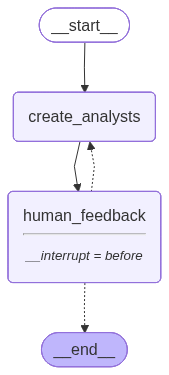

In [41]:
# Graph
analyst_builder = StateGraph(CreateAnalystState)

analyst_builder.add_node("create_analysts", create_analysts)
analyst_builder.add_node("human_feedback", human_feedback)

analyst_builder.add_edge(START, "create_analysts")
analyst_builder.add_edge("create_analysts", "human_feedback")
analyst_builder.add_conditional_edges("human_feedback", human_feedback_router, ["create_analysts", END])

# Compile
memory = MemorySaver()
analyst_graph = analyst_builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View Graph
display(Image(analyst_graph.get_graph(xray=1).draw_mermaid_png()))

In [42]:
# Test
max_analysts = 3
topic = "Why python is the best language for AI development?"
thread = {"configurable": {"thread_id": 1}}

# Run the graph until the first interruption
for event in analyst_graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: University of Computer Science
Role: Computer Science Educator
description: Dr. Emily Chen is a renowned computer science educator with a focus on programming languages. She emphasizes Python's role in AI education due to its simplicity and readability, which make it an ideal language for students and educators alike. Her perspective highlights Python's built-in libraries and how its syntax lowers barriers to entry for beginners, thereby fostering a larger community of aspiring AI developers.
--------------------------------------------------
Name: Raj Patel
Affiliation: TechCorp Innovations
Role: AI Systems Developer
description: Raj Patel is an experienced AI systems developer working at TechCorp Innovations. He advocates for Python as the best language for AI development due to its extensive ecosystem of libraries and frameworks like TensorFlow and PyTorch, which facilitate rapid prototyping and deployment of AI solutions. His viewpoint emphasizes P

In [43]:
state = analyst_graph.get_state(thread)
state.next

('human_feedback',)

In [44]:
# Update state
analyst_graph.update_state(thread, {
    "human_feedback": "include one persona from startup view, one data scientist, and one ai engineer"
},as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f093093-c346-6ae6-8002-8ea365a9af77'}}

In [12]:
for event in analyst_graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Jane Smith
Affiliation: University of Technology's Department of Computer Science
Role: Academic Researcher in Programming Languages
Description: Dr. Jane Smith is an academic researcher with a focus on programming languages and their applications in various domains, including artificial intelligence. She explores the technical strengths and weaknesses of different programming languages, with particular interest in syntax complexity, execution speed, and library support, to determine their suitability for AI projects. Her analysis includes comparison with other languages commonly used in AI development to contextualize Python's advantages and limitations.
--------------------------------------------------
Name: Mark Johnson
Affiliation: Tech Insights Journal
Role: Tech Industry Analyst
Description: Mark Johnson is a tech industry analyst who examines trends and adoption rates of technologies within the industry. He focuses on why businesses and developers prefer certain progr

In [13]:
final_state = analyst_graph.get_state(thread)
final_state.next

('human_feedback',)

In [14]:
# If we are satisfied, then we simply supply no feedback
analyst_graph.update_state(thread, {"human_feedback": None},as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f092f3b-2aec-6e7a-8004-9a2e548ed900'}}

In [15]:
for event in analyst_graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Jamie Patel
Affiliation: Emerging AI Startup
Role: Startup Founder
Description: Jamie is the founder of a small but promising AI startup. Their focus is on leveraging innovative AI solutions to solve everyday problems. Jamie is particularly interested in Python because of its extensive support community and the ecosystem of libraries that allow rapid prototyping and deployment, which is crucial for startups to stay agile and responsive to market demands. They advocate for Python as the backbone of their development stack due to its versatility and ease of learning, which helps in efficiently scaling their team with new developers as the company grows.
--------------------------------------------------
Name: Dr. Amelia Wang
Affiliation: Leading Data Science Consultancy
Role: Senior Data Scientist
Description: Dr. Amelia Wang is a senior data scientist with over a decade of experience in data analysis and machine learning. She deeply values Python for its rich set of libraries like

In [16]:
final_state = analyst_graph.get_state(thread)
final_state.next

()

---
# 2. Research Phase
After successfully implementing the Anlyst (perspective) generation with Human-in-the-loop for verification, next step is to implement research phase. In this part each analyst will go through a conversation with an expert capable of searching the web and Wikipedia.
The reason for choosing conversation between analyst and expert is inspired by the idea of while we find answer to our question, simultaneously we face new question. that is why conversation with multiple turns is choosed for this part to gather in-depth context about the topic/question asked by user.

Research phase has following flow:
1. Generate question to be asked from the expert.
2. Generate search query to find the answer of question from the web.
3. search the Web and Wikipedia in parallel.
4. generate answer to question by gathered context.
5. repeat until satisfaction.
6. generate a clean report from questions and asnwers.

In [13]:
# States
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source documents
    analyst: Analyst # Analyst asking questions
    transcript: str # Interview transcript
    report: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

## 2.1 Generate Question

In [14]:
# Prompts
question_instructions_prompt = PromptTemplate(
    input_variables=["analyst_name", "analyst_role", "analyst_affiliation", "analyst_description"],
    template = """You act as {analyst_name}. a {analyst_role} at {analyst_affiliation}. {analyst_description}.
    
You are tasked with interviewing an expert to learn more about your area of focus.
You have a clear goal: to create spiecific questions to understand your research area which will be asked from an expert.
You should breakdown complex topics by question asking to understand facts and insights that people will find non-obvious, You also avoid generalities and are precise.

Here is the guideline for you:
1. Analyse the conversation if provided to understand the context.
1. Begin by asking the first question and continue to drilldown and refine your understandings of the topic if no previos conversation was found.
2. on each call, generate a single specific question that helps you understand topic deeper. 
2. Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
3. When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"
"""
)

In [15]:
# Node
def generate_question(state: InterviewState):
    """ Node to generate a question """
    messages = state["messages"]
    analyst = state["analyst"]

    # Generate question with LLM
    system_message = question_instructions_prompt.format(
        analyst_name=analyst.name,
        analyst_role=analyst.role,
        analyst_affiliation=analyst.affiliation,
        analyst_description=analyst.description
    )
    question = llm.invoke([system_message]+messages)

    # Add metadata to question
    question.name = re.sub(r'[\s<|\\/>]+', '_', analyst.name).lower()
    question.message_type = "question"

    # Add question into messages
    return {"messages": [question]}

In [20]:
test_state = InterviewState(
    analyst=analysts[1],
    topic="why python is good for data science?",
    messages=[HumanMessage("So you want to understand more why python is the best option for data science")]
)

state = generate_question(test_state)

In [21]:
state["messages"][-1].content

'What are the key features of Python that make it particularly suited for data science and machine learning tasks compared to other programming languages?'

## 2.2 Context Engineering
The expert can gather information from multiple sources in parallel to answer questions.
for example we can use:
1. Specific websites
2. RAG
3. Web search
4. Wikipedia

In this notebook web search and wikipedia has been used.

In [16]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

# Web search tool
from langchain_tavily import TavilySearch
tavily_search = TavilySearch(tavily_api_key=config.tavily_api_key.get_secret_value(),max_results=3)

In [17]:
# Prompts
query_generation_prompt = PromptTemplate(
    input_variables=["search_source"],
    template="""You are a professional {search_source} search query generation agent. Your task is to analyze the full conversation
between two analyst AI and expert AI to understand the context. pay particullar attention to the final question provided by analyst 
and convert its question into a well-structured {search_source} search query so expert can use it to gather context from the internet 
before answering the question. 

If you are generating query for search engine, You can ask questions realed to the topic as search query. But if you are generating 
query for wikipedia, instead of asking questions, write single or max 2 words search query related to the topic since wikipedia gives
articles about the search query topic.
"""
)

In [18]:
# Nodes
def search_web(state: InterviewState):
    """Node to perform web search using Tavily"""
    messages = state["messages"]

    # Generate search query
    system_message = query_generation_prompt.format(search_source="search engine")
    search_query = llm.with_structured_output(SearchQuery).invoke([SystemMessage(content=system_message)]+messages)

    # Perform search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format
    formatted_search_docs = [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    
    return {"context": formatted_search_docs} 


def search_wikipedia(state: InterviewState):
    """Node to perform wikipedia search"""
    messages = state["messages"]

    # Generate search query
    system_message = query_generation_prompt.format(search_source="wikipedia")
    search_query = llm.with_structured_output(SearchQuery).invoke([SystemMessage(content=system_message)]+messages)

    # Perform search
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    # Format
    formatted_search_docs = [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]

    return {"context": formatted_search_docs}

## 2.3 Generate Answer

After filling the context window, we synthesize them into a comprehensive report so later we can use it to generate the final response. 

Also we need a writer section to analyze all context and write a report, in simple words we reuse the persona of analyst but this time instead of asking questions, it sum up everything as a comprehensive report.

In [19]:
# Prompt
answer_generation_prompt = PromptTemplate(
    input_variables=["analyst_name", "analyst_description", "context"],
    template="""You are an expert being intervied by {analyst_name}. {analyst_description}.
Your goal is to answer the last question posed by the interviewer. 

When you are answering questions, follow these guideline:

1. Use only the information provided in the context at the end of this message.
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. The context contain sources at the topic of each individual document, Include these sources in your answer next to any relavant statement. For example, for source #1 use [1].
4. List all your sources in order at the bottom of your answer. [1] source 1, [2] source 2, et.

To answer the question, use the following context delimited in triple backticks: ```{context}```
"""
)


report_instructions_prompt = PromptTemplate(
    template="""You are an expert technical writer. 
    
You will write a concise, readable **markdown report section** based on a transcript of a technical interview (questions from an analyst 
and answers from an expert) and a set of source documents (each with a <Document> tag plus a name and content). **Rely entirely on 
information from the transcript and these source documents.**

**Your instructions:**
1. Carefully read and analyze** both the transcript and each source document. Identify the most significant new insights, clarifications, and supporting evidence.

2. Write the report following this structure (use only markdown):
a. Title (## header)
b. Summary (### header)
c. Sources (### header)
    
3. Start with a clear, engaging title as a top-level (##) markdown header.
    
4. Add a **Summary** (### subheader):  
    - Briefly introduce background and the relevance of the topic.
    - Present major findings, novel points, or surprising conclusions from the interview and source documents.
    - Present the summary as concise paragraphs and ordered or unordered lists as appropriate.
    - Cite sources with numbered brackets (e.g., [1], [2]) immediately after the information sourced.
    - Do not include the names/titles of the analyst or expert, nor mention you are an AI or technical writer
     - Do not copy sentences verbatim—**synthesize and rephrase for clarity**.

5. Add a Sources section (### subheader):  
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

6. Other guidelines:
    - Stay under 400 words.
    - **Do not add metadata, introductions, or footers outside the required structure.**
    - Only provide citations for information taken directly from the transcript or documents. **No hallucinations.**
    - Before finalizing, check for redundant sources or headers and correct numbering.
    - Use professional, informative, but approachable language.

**Remember:**
- Your output should be clear to both technical and non-technical readers.
- Prioritize accuracy, brevity, and structure.
"""
)


In [20]:
# Nodes
def generate_answer(state: InterviewState):
    """Node to generate answer for the question using context"""
    messages = state["messages"]
    analyst = state["analyst"]
    context = state["context"]

    # Generate answer
    system_message = answer_generation_prompt.format(
        analyst_name=analyst.name, 
        analyst_description=analyst.description,
        context="\n\n".join(context)
    )
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Add metadata to answer
    answer.name = "expert"
    answer.message_type = "answer"

    # Add answer into messages
    return {"messages": [answer]}
    
    
def conversation_router(state: InterviewState):
    """
    Router to determine route after answer generation.
    
    Possible paths are:
    1- ask next question.
    2- finish conversation loop
    """
    messages = state["messages"]
    max_num_turns = state["max_num_turns"]

    # Check the number of expert answers
    num_response = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == 'expert']
    )

    # End if expert has answered more than the max turns
    if num_response >= max_num_turns:
        return "save_interview"

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    
    return "generate_question"


def save_interview(state: InterviewState):
    """Node to save whole conversation as a string"""
    messages = state["messages"]

    # Conver BaseMessages to a string
    transcript = get_buffer_string(messages)

    # Save the interview
    return {"transcript": transcript}


def write_report(state: InterviewState):
    """Node to write final report extracted from conversation"""

    context = state["context"]
    transcript = state["transcript"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = report_instructions_prompt.format()
    user_content = f"""INTERVIEW TRANSCRIPT: ```{transcript}``` \n\n SOURCE DOCUMENTS: ```{context}```"""
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=user_content)]) 

    # Append it to state
    return {"report": [report.content]}

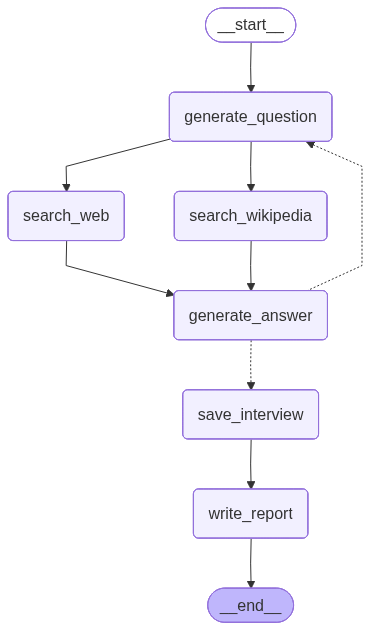

In [21]:
interview_builder = StateGraph(InterviewState)

interview_builder.add_node("generate_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_report", write_report)


interview_builder.add_edge(START, "generate_question")
interview_builder.add_edge("generate_question", "search_web")
interview_builder.add_edge("generate_question", "search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges("generate_answer", conversation_router, ["save_interview", "generate_question"])
interview_builder.add_edge("save_interview", "write_report")
interview_builder.add_edge("write_report", END)


# Compile
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory)

# View Graph
display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))

In [34]:
thread = {"configurable": {"thread_id": 323456}}
test_state = InterviewState(
    analyst=analysts[1],
    max_num_turns=3,
    messages=[]
)

for event in graph.stream(test_state, thread, stream_mode="values"):
    print(event, "\n")

{'messages': [], 'max_num_turns': 3, 'context': [], 'analyst': Analyst(affiliation='Leading Data Science Consultancy', name='Dr. Amelia Wang', role='Senior Data Scientist', description="Dr. Amelia Wang is a senior data scientist with over a decade of experience in data analysis and machine learning. She deeply values Python for its rich set of libraries like Pandas and Scikit-learn that streamline the data cleaning and modeling phases. Amelia often cites Python's readability and simplicity as vital characteristics that enhance collaboration within her team, enabling clear communication of methodologies and results. Her motivation to advocate for Python comes from its ability to seamlessly integrate data analysis with machine learning workflows, providing a cohesive environment that fosters innovation.")} 

{'messages': [AIMessage(content="Certainly! Let's begin the interview with the expert by focusing on understanding specific aspects of integrating machine learning workflows using Py

In [36]:
from IPython.display import Markdown
state = graph.get_state(thread)
Markdown(state.values["report"][0])

## Leveraging Python Libraries for Machine Learning Workflows

### Summary

Integrating machine learning (ML) workflows using Python offers substantial efficiencies, particularly through the use of libraries such as Pandas and Scikit-learn. These libraries streamline the transition from data analysis to model development by providing a cohesive environment for data manipulation and machine learning tasks.

Key advantages include:

- **Data Manipulation and Cleaning**: Pandas enables efficient handling and preprocessing of data, which is crucial for cleaning and transforming raw datasets for ML applications [1].
- **Seamless Development Environment**: Scikit-learn complements Pandas by offering an extensive suite of machine learning algorithms and preprocessing tools that are designed to work seamlessly with other scientific libraries such as NumPy and SciPy [1][2].

The role of Scikit-learn's Pipelines is particularly noteworthy:

- **Reproducibility and Consistency**: Pipelines encapsulate processing steps, ensuring data preprocessing and model fitting are applied consistently. This reduces errors because each step is automatically repeated with new data, enhancing overall reproducibility [3][4].
- **Simplified Workflow Management**: Pipelines reduce code complexity by chaining together sequences of data transformations and model training into a single, manageable unit. This modular approach assists users in maintaining organized workflows [4][5].
- **Efficient Parameter Tuning**: Through Pipelines, users can conduct hyperparameter tuning more effectively, as every combination of preprocessing and model configurations can be explored without manual intervention [4].

Scikit-learn is widely leveraged across various industries, including finance and retail, to handle tasks like fraud detection and predictive analytics, demonstrating its practical utility in real-world applications [6].

Overall, Python's machine learning libraries enhance workflow efficiency by supporting seamless integration of data manipulation, model development, and process optimization.

### Sources
[1] https://stackoverflow.com/questions/66114523/should-one-use-pandas-or-sklearn-for-imputation-normalization-etc  
[2] https://machinelearningmastery.com/how-to-combine-pandas-numpy-and-scikit-learn-seamlessly/  
[3] https://medium.com/@sahin.samia/scikit-learn-pipelines-explained-streamline-and-optimize-your-machine-learning-processes-f17b1beb86a4  
[4] https://www.kdnuggets.com/streamline-your-machine-learning-workflow-with-scikit-learn-pipelines  
[5] https://www.labellerr.com/blog/end-to-end-ml-pipeline/  
[6] https://en.wikipedia.org/wiki/Scikit-learn  

---
# Finilize the Graph

In [22]:
class ResearchGraphState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    analysts = List[Analyst]  # Analysts persona
    human_feedback: str  # Human feedback for analysts
    sections: Annotated[list, operator.add]  # conversations report
    introduction: str  # Introduction for the final report
    content: str  # Content for the final report
    conclusion: str  # Conclusion for the final report
    final_report: str  # Final report

In [23]:
# New router node for initiating interviews in parallel
def initiate_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    
    human_feedback = state.get("human_feedback", None)

    # Check if human feedback is provided
    if human_feedback:
        # return to create_analyst node
        return "create_analysts"
    
    # Start interviews in parallel using Send() API
    topic = state["topic"]
    return [Send(
        "conduct_interview", 
        {
            "analyst": analyst
        }
    ) for analyst in state["analysts"]]

In [24]:
# Prompts
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [25]:
# Nodes
def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}


def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

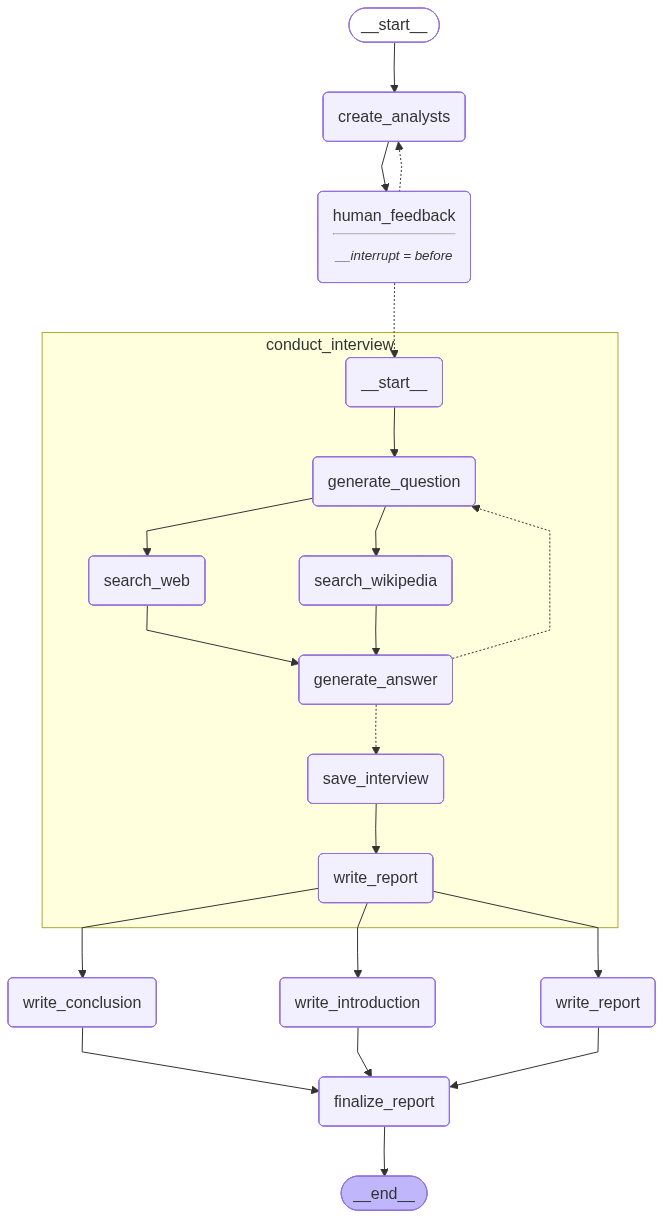

In [26]:
# Graph
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_report",write_report)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [27]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Digital Transformation Think Tank
Role: Technology Strategist
Description: Dr. Emily Carter is a technology strategist specializing in emerging digital frameworks and platforms. Her primary focus is on assessing the strategic benefits and long-term impacts of adopting innovative technologies like LangGraph. She is particularly concerned with how such technologies can drive efficiency, scalability, and competitive advantage within organizations. Emily is motivated by the desire to help companies navigate the complexities of digital transformation and stay ahead in the fast-paced tech landscape.
--------------------------------------------------
Name: Rajesh Iyer
Affiliation: Global Tech Consultancy Firm
Role: Software Development Expert
Description: Rajesh Iyer is a seasoned software development expert with extensive experience in implementing advanced programming frameworks. He is focused on evaluating the technical benefits and potential challenges 

In [29]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f093086-db4b-63b0-8002-cbf85f45f3f6'}}

In [30]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Digital Transformation Think Tank
Role: Technology Strategist
Description: Dr. Emily Carter is a technology strategist specializing in emerging digital frameworks and platforms. Her primary focus is on assessing the strategic benefits and long-term impacts of adopting innovative technologies like LangGraph. She is particularly concerned with how such technologies can drive efficiency, scalability, and competitive advantage within organizations. Emily is motivated by the desire to help companies navigate the complexities of digital transformation and stay ahead in the fast-paced tech landscape.
--------------------------------------------------
Name: Rajesh Iyer
Affiliation: Global Tech Consultancy Firm
Role: Software Development Expert
Description: Rajesh Iyer is a seasoned software development expert with extensive experience in implementing advanced programming frameworks. He is focused on evaluating the technical benefits and potential challenges 

In [38]:
# Confirm we are happy
graph.update_state(thread, {"human_feedback": 
                            None}, as_node="human_feedback")

KeyError: 'analysts'

In [36]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
create_analysts
--Node--
__interrupt__


In [33]:
state = graph.get_state(thread)

In [34]:
state.next

('human_feedback',)